In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install efficientnet_pytorch
!pip install pydicom

# -*- coding: utf-8 -*-
from torchvision import datasets, transforms, models
import torch
from torch import nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data.dataloader import default_collate
from efficientnet_pytorch import EfficientNet
import numpy as np
import pydicom
import matplotlib.pyplot as plt
import glob
import os
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from PIL import Image

In [3]:
data_dir = "/content/drive/Shared drives/數位醫學/Case Presentation 2"

# hyper parameters
num_classes = 6
batch_size = 16
EPOCH = 150
input_size = 512

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# windowing
def correct_dcm(dcm):
    x = dcm.pixel_array + 1000
    px_mode = 4096
    x[x>=px_mode] = x[x>=px_mode] - px_mode
    dcm.PixelData = x.tobytes()
    dcm.RescaleIntercept = -1000

def window_image(dcm, window_center, window_width):
    
    if (dcm.BitsStored == 12) and (dcm.PixelRepresentation == 0) and (int(dcm.RescaleIntercept) > -100):
      correct_dcm(dcm)
    
    img = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    img_min = window_center - window_width // 2
    img_max = window_center + window_width // 2
    img = np.clip(img, img_min, img_max)

    return img

def bsb_window(dcm):
    brain_img = window_image(dcm, 40, 80)
    subdural_img = window_image(dcm, 80, 200)
    #soft_img = window_image(dcm, 40, 380)
    bone_img = window_image(dcm , 600 , 2800)

    brain_img = (brain_img - 0) / 80
    subdural_img = (subdural_img - (-20)) / 200
    #soft_img = (soft_img - (-150)) / 380
    bone_img = (bone_img - (-800)) / 2800

    #bsb_img = np.array([brain_img, subdural_img, soft_img]).transpose(1,2,0)
    bsb_img = np.array([brain_img, subdural_img, bone_img]).transpose(1,2,0)

    return bsb_img

In [5]:
class myDataset(Dataset):
  def __init__(self, folder, classes, transform=None):

    self.dictonary = {'epidural':0, 'healthy':1, 'intraparenchymal':2, 'intraventricular':3, 'subarachnoid':4, 'subdural':5}
    self.path = []
    self.label = []
    self.transform = transform

    # train data
    # self.path存dcm的path
    # self.label存dcm的label
    if len(classes) > 0:
      for i in classes:
        for j in glob.glob(folder + '/' + i + '/*'):
          self.path.append(j)
          self.label.append(self.dictonary[i])
    # test data的部分之後寫
    # 可能再寫一個test data的myDataset
    #else:
      #pass

  def __len__(self):
    return len(self.path)
 
  def __getitem__(self, idx):
    #img = torch.from_numpy(bsb_window(pydicom.dcmread(self.path[idx])).transpose(2, 0, 1)).type(torch.FloatTensor)

    img = bsb_window(pydicom.dcmread(self.path[idx])) # C*H*W => H*W*C
    # 以下動作使得圖片得以轉為PIL，才能使用部分的transform
    img *= 255 # [0., 1.] => [0., 255.]
    img = img.astype(np.uint8) # [0., 255.] => [0, 255]
    img = Image.fromarray(img) # numpy => PIL

    #print(np.max(np.array(img)), np.min(np.array(img)), np.mean(np.array(img)), np.median(np.array(img)))
    if self.transform:
      img = self.transform(img)
    #print(torch.max(img), torch.min(img), torch.mean(img), torch.median(img))
    return img, self.label[idx]

classes = ['epidural', 'healthy', 'intraparenchymal', 'intraventricular', 'subarachnoid', 'subdural']

# data augmentation
data_transforms2 = transforms.Compose([
  #transforms.ToPILImage(),                                       
  transforms.RandomHorizontalFlip(p=0.5),
  transforms.RandomRotation(degrees=15),
  transforms.RandomResizedCrop(input_size, scale=(0.85, 1.0), ratio=(0.8, 1.2)),
  transforms.ToTensor(), # PIL => FloatTensor，[0, 255] => [0., 1.]
])

TrainDataset = myDataset(folder='/content/drive/Shared drives/數位醫學/Case Presentation 2/TrainingData_tmp', classes=classes, transform=data_transforms2)


validation_split = .1
shuffle_dataset = True
random_seed = 2020

dataset_size = len(TrainDataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset:
  np.random.seed(random_seed)
  np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, sampler=train_sampler, num_workers=4)
validation_loader = torch.utils.data.DataLoader(TrainDataset, batch_size=batch_size, sampler=valid_sampler, num_workers=4)

In [6]:
# load pretrained weight(trained from ImageNet)
net = models.resnet50(pretrained=True)

#set_parameter_requires_grad(net, feature_extract)
num_ftrs = net.fc.in_features
net.fc = nn.Linear(num_ftrs, 6)
net = net.to(device)
input_size = 512

In [7]:
ii = 0
LR = 0.0005  # learning rate
best_acc = 0  # initialize best test accuracy

# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
#optimizer = optim.Adam(net.parameters(), lr=LR)
optimizer = optim.Adam(net.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-9)
#optimizer = optim.SGD(net.parameters(), lr=LR, momentum=0.9)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)

In [8]:
import datetime
## modified region ## 
iter_train = []
loss_train = []
loss_val = []
acc_train = []
valid_acc_train = []
epoch_train = []
## modified region ## 
best_val_acc = 0.0
best_val_loss = 10.0

for epoch in range(EPOCH):
  net.train()
  sum_loss = 0.0
  correct = 0.0
  total = 0.0
  ## modified region ## 
  LOSS_TRAIN = 0.0
  starttime = datetime.datetime.now()
  # training
  for i, data in enumerate(train_loader, 0):
    length = len(train_loader)
    input, target = data
    #print(target, type(target))
    input, target = input.to(device), target.to(device)
    
    optimizer.zero_grad()

    output = net(input)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()

    sum_loss += loss.item()
    _, predicted = torch.max(output.data, 1)
    total += target.size(0)
    correct += predicted.eq(target.data).cpu().sum()
    if i % 80 == 0:
      print('[epoch:%d, iter:%d] Loss: %.03f | Acc: %.3f%% ' 
        % (epoch + 1, (i + 1 + epoch * length), sum_loss / (i + 1),
        100. * float(correct) / float(total)))
    LOSS_TRAIN = sum_loss / (i + 1)

  ## modified region ##    
  epoch_train.append(epoch)
  loss_train.append(LOSS_TRAIN)
  acc_train.append(100. * float(correct) / float(total))   
  ## modified region ## 

   
    
  # validation
  with torch.no_grad():
    correct = 0
    total = 0
    val_sum_loss = 0
    LOSS_VAL = 0
    for i, data in enumerate(validation_loader, 0):
      net.eval()
      images, labels = data
      images, labels = images.to(device), labels.to(device)
      #outputs = net(images)
      output = net(images)
      loss = criterion(output, labels)
      val_sum_loss += loss.item()
      # 取得分最高的那個類 (outputs.data的索引號)
      _, predicted = torch.max(output.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).cpu().sum()
      LOSS_VAL = val_sum_loss / (i + 1)
    loss_val.append(LOSS_VAL)
    print('validation accuracy：%.3f%%' % (100. * float(correct) / float(total)))
    print('loss: ', LOSS_VAL)
    ## modified region ## 
    valid_acc_train.append(100. * float(correct) / float(total))
    ## modified region ## 
    acc = 100. * float(correct) / float(total)
    if best_val_acc < acc:
      print("save weight!!(acc)")
      torch.save(net, '/content/drive/Shared drives/數位醫學/Case Presentation 2/Implementation/weights/model=resnet50(acc).pkl')
      best_val_acc = acc
    if best_val_loss > LOSS_VAL:
      print("save weight!!(loss)")
      torch.save(net, '/content/drive/Shared drives/數位醫學/Case Presentation 2/Implementation/weights/model=resnet50(loss).pkl')
      best_val_loss = LOSS_VAL
    scheduler.step(acc)
  endtime = datetime.datetime.now()
  print((endtime - starttime).seconds," seconds")
    


print("Training Finished, Total EPOCH=%d" % EPOCH)

[epoch:1, iter:1] Loss: 1.797 | Acc: 12.500% 
[epoch:1, iter:81] Loss: 1.749 | Acc: 25.926% 
[epoch:1, iter:161] Loss: 1.714 | Acc: 28.727% 
[epoch:1, iter:241] Loss: 1.688 | Acc: 29.927% 
[epoch:1, iter:321] Loss: 1.682 | Acc: 30.238% 
validation accuracy：28.500%
loss:  1.6958009851606268
save weight!!(acc)
save weight!!(loss)
391  seconds
[epoch:2, iter:339] Loss: 1.520 | Acc: 43.750% 
[epoch:2, iter:419] Loss: 1.627 | Acc: 32.870% 
[epoch:2, iter:499] Loss: 1.596 | Acc: 34.783% 
[epoch:2, iter:579] Loss: 1.573 | Acc: 36.437% 
[epoch:2, iter:659] Loss: 1.577 | Acc: 35.962% 
validation accuracy：40.000%
loss:  1.4995850857935453
save weight!!(acc)
save weight!!(loss)
304  seconds
[epoch:3, iter:677] Loss: 1.426 | Acc: 43.750% 
[epoch:3, iter:757] Loss: 1.546 | Acc: 37.809% 
[epoch:3, iter:837] Loss: 1.534 | Acc: 37.927% 
[epoch:3, iter:917] Loss: 1.521 | Acc: 37.941% 
[epoch:3, iter:997] Loss: 1.520 | Acc: 38.065% 
validation accuracy：39.833%
loss:  1.4693977707310726
save weight!!(los

KeyboardInterrupt: ignored

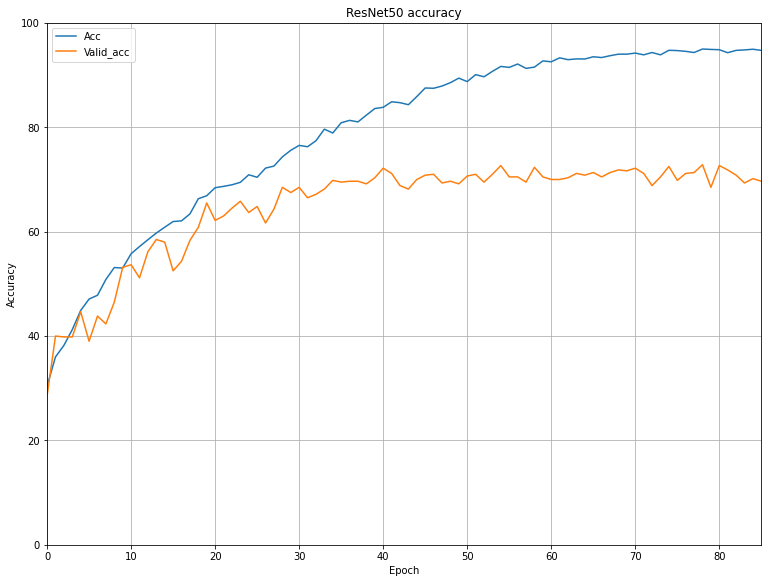

In [9]:
plt.figure(figsize=(12.8, 9.6)) 
plt.xlabel("Epoch")
plt.xlim(0 , len(epoch_train)-1)
plt.ylim(0 , 100)
plt.ylabel("Accuracy") 
plt.title("ResNet50 accuracy")
plt.plot(epoch_train , acc_train , label = "Acc")
#plt.plot(epoch_train , loss_train , label = "Loss")
plt.plot(epoch_train , valid_acc_train , label = "Valid_acc")
plt.legend(loc="upper left")
plt.grid()
plt.show()  
#plt.savefig("ResNet50.jpg")

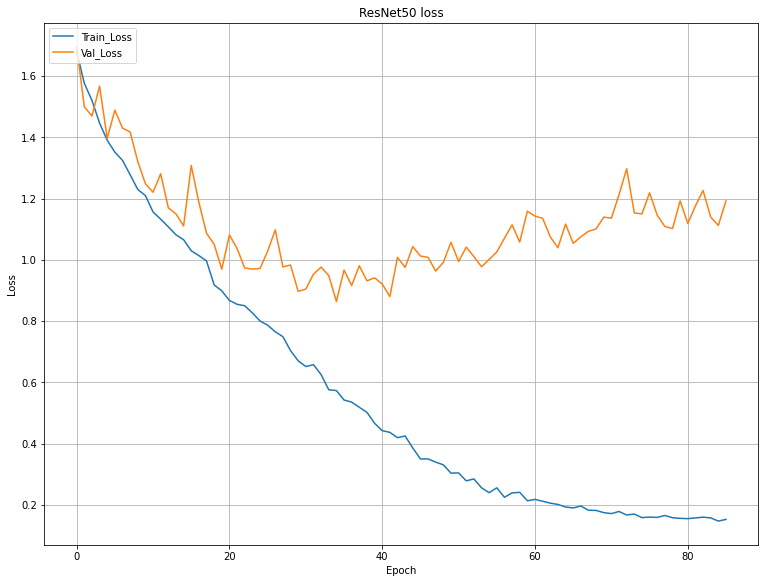

In [11]:
plt.figure(figsize=(12.8, 9.6)) 
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("ResNet50 loss")
#plt.ylim(0 , 4)
plt.grid()
plt.plot(epoch_train , loss_train , label = "Train_Loss")
plt.plot(epoch_train , loss_val, label='Val_Loss')
plt.legend(loc="upper left")